# SDSSJ1730+5545

In [1]:
import json,urllib,glob,os
from zipfile import ZipFile
from math import ceil

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from lightkurve import TessTargetPixelFile
from astropy.wcs import WCS
import eleanor

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
output_notebook()



Loading BokehJS ...

In [2]:
name = 'SDSSJ1730+5545'
with open('response.json','r') as JSON:
    rdic = json.load(JSON)
sourcetess = rdic[name]

sourcetess['ra']
sourcecoord = "{} +{}".format(sourcetess['ra'],sourcetess['dec'])
print(sourcecoord)



lk.search_tesscut(sourcecoord)


262.69829166666665 +55.75513888888889


SearchResult containing 5 data products.

             target_name              productFilename         description         distance
------------------------------------- --------------- --------------------------- --------
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 14)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 15)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 16)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 17)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 18)      0.0

# First Sector

In [3]:
sectornum = 14
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')

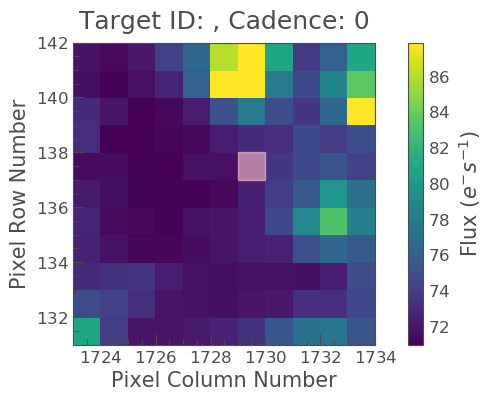

In [4]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

# Guess closest Pixel

In [5]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=np.flip(dataeleanor.aperture.astype(bool),0))
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [6]:
tpf.interact_sky(magnitude_limit=20) 

In [7]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 40


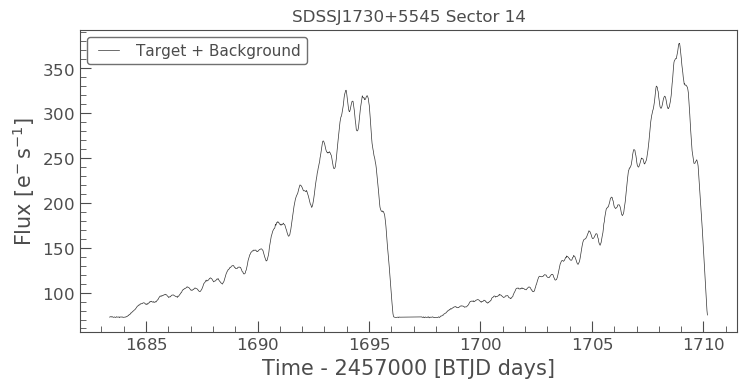

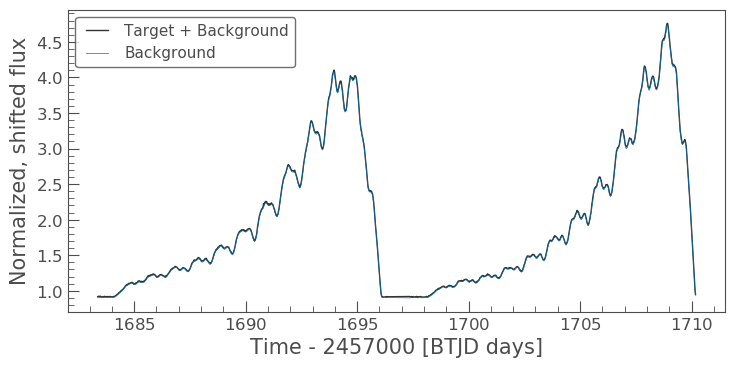

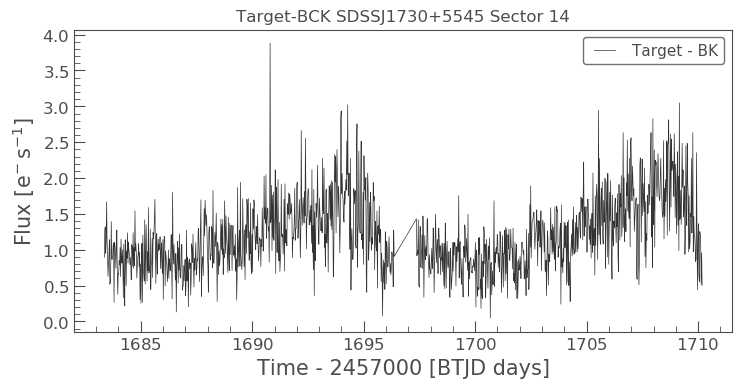

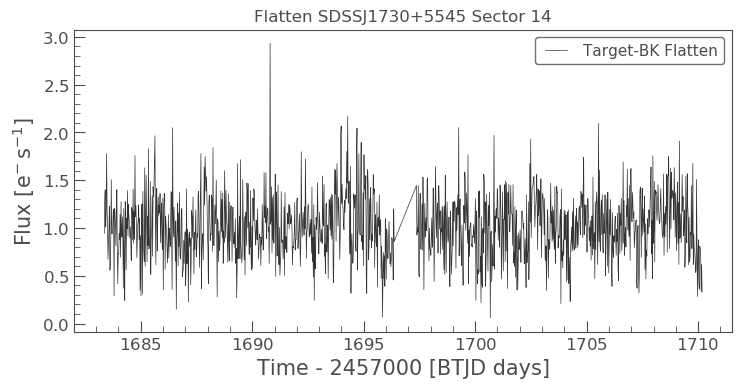

In [8]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


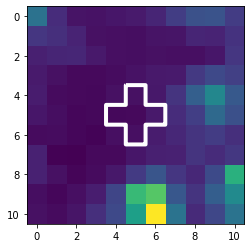

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


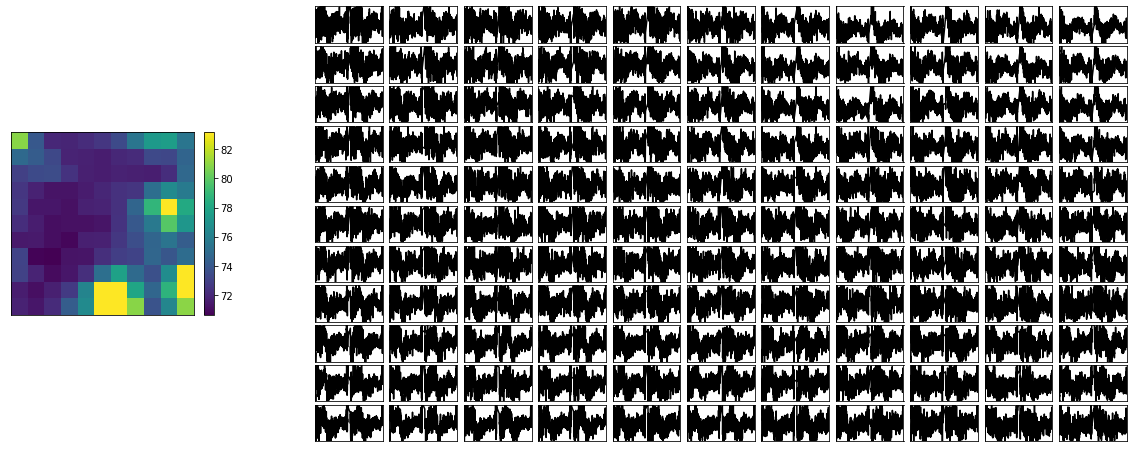

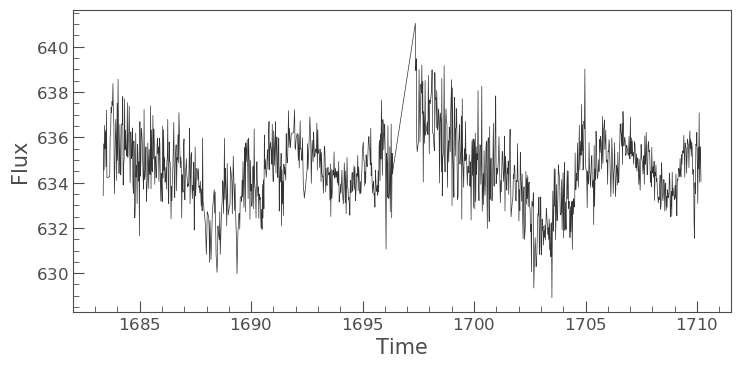

In [9]:
sectornum = 14
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Sector 15

In [10]:
sectornum = 15
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    

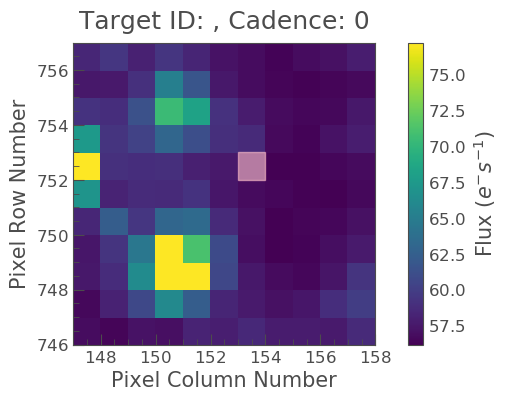

In [11]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [12]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [13]:
tpf.interact_sky(magnitude_limit=20)

In [14]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 12


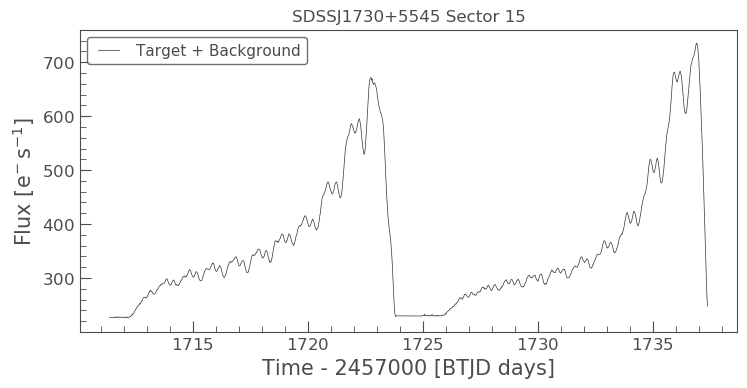

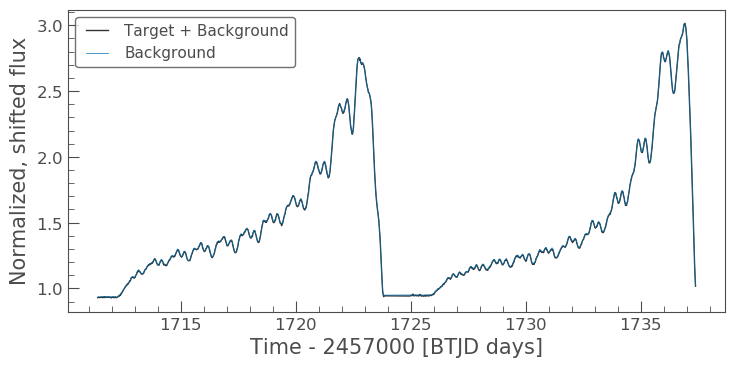

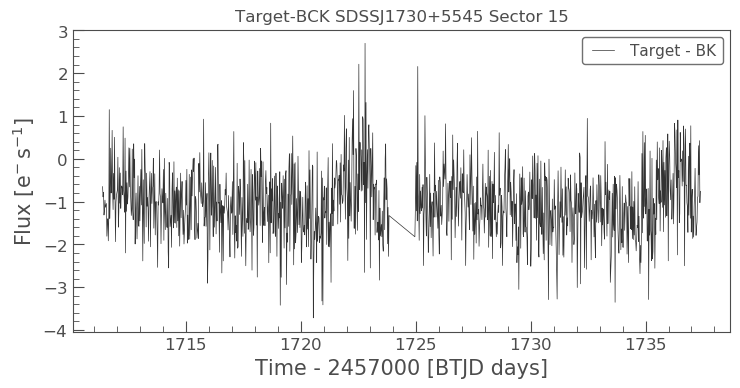

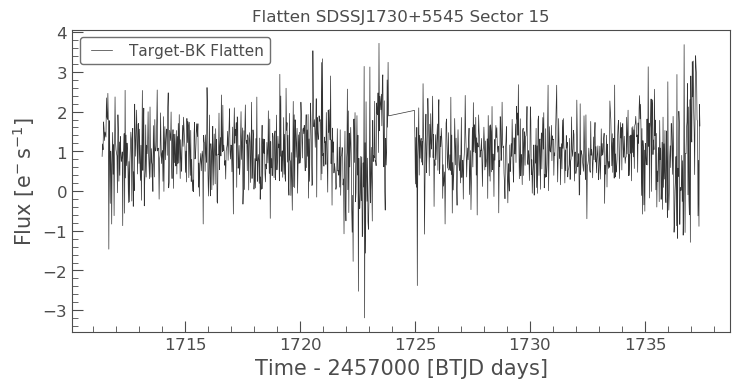

In [17]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


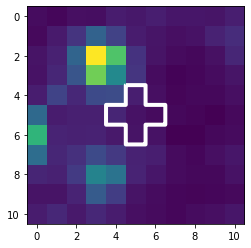

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


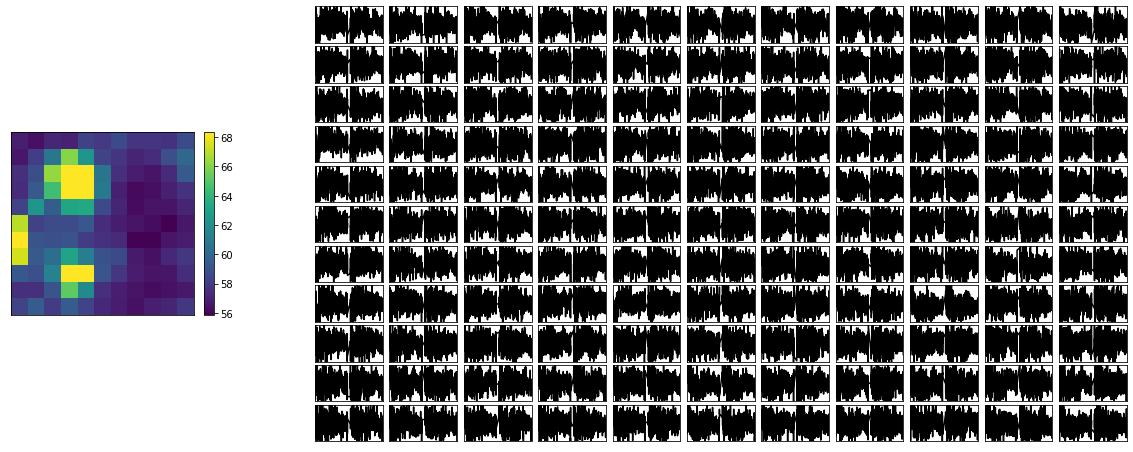

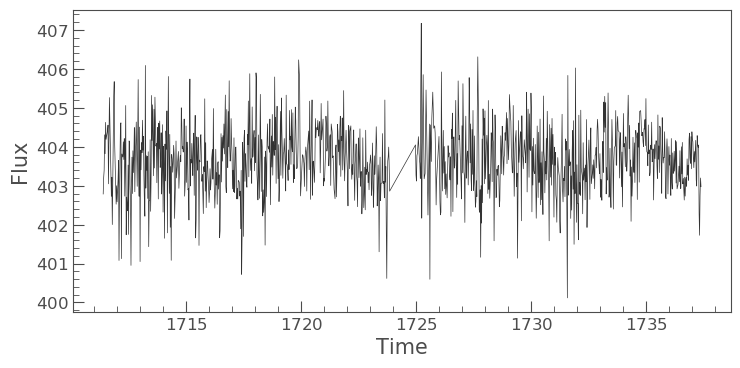

In [16]:
sectornum = 15
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Other Sector

In [18]:
sectornum = 16
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    


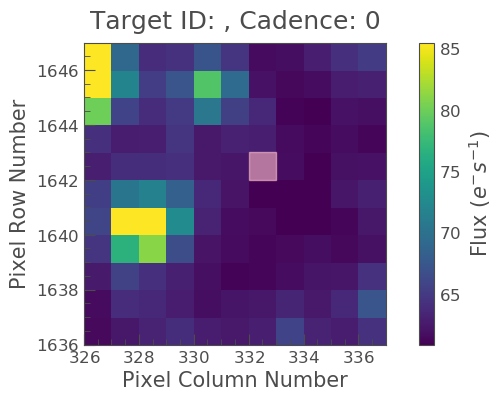

In [19]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [20]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [21]:
tpf.interact_sky(magnitude_limit=20)

In [22]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 9


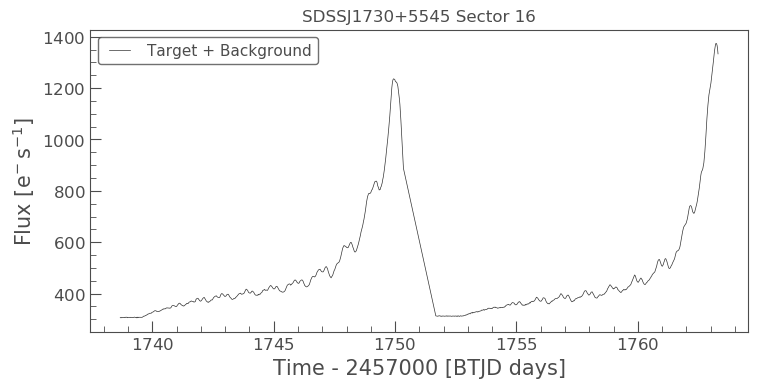

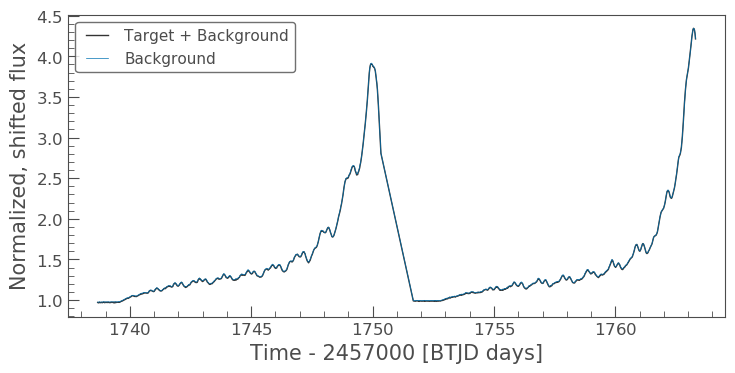

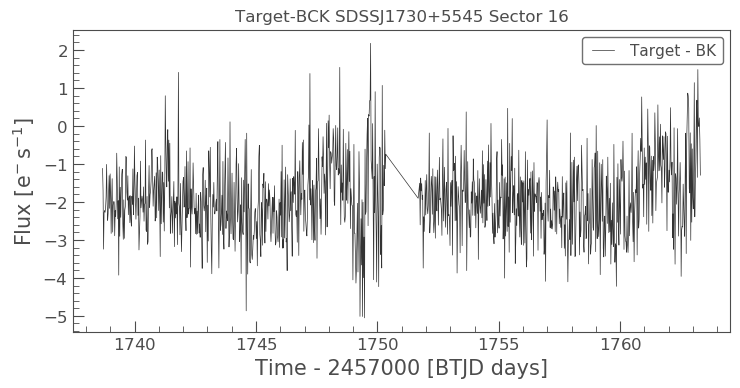

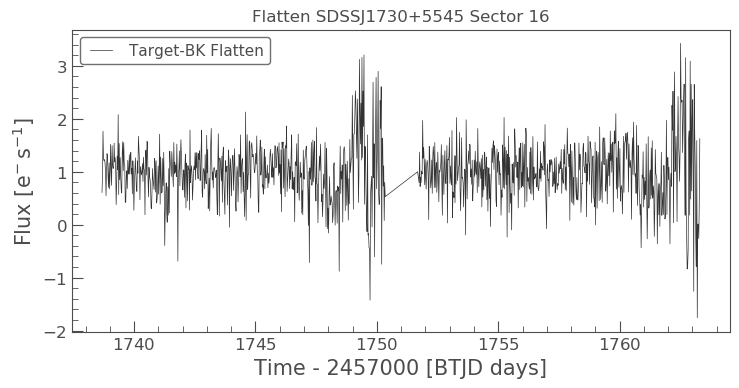

In [23]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


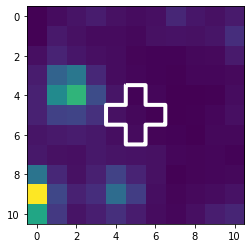

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


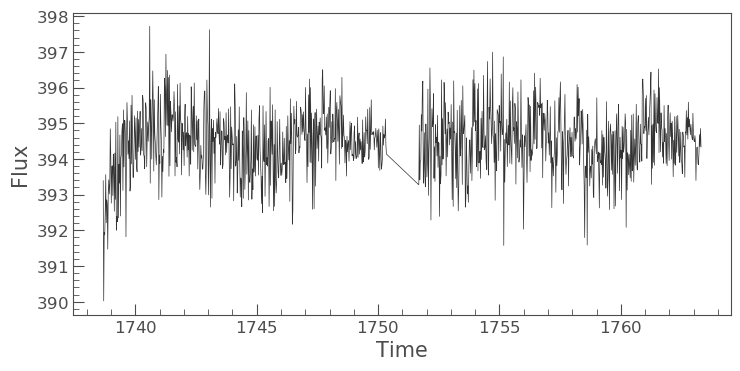

In [24]:
sectornum = 16
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


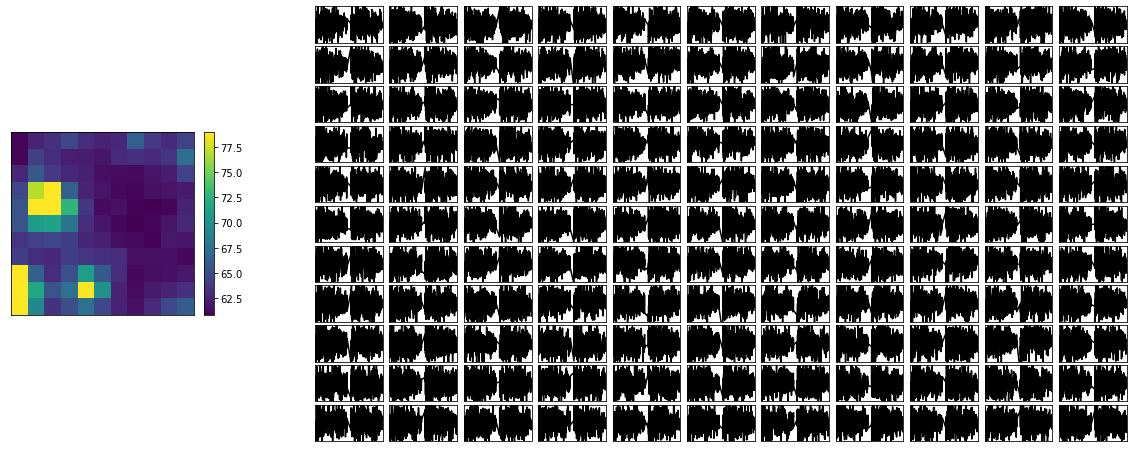

In [25]:
fig = vis.pixel_by_pixel()

# SEctor 17

In [26]:
sectornum = 17
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    





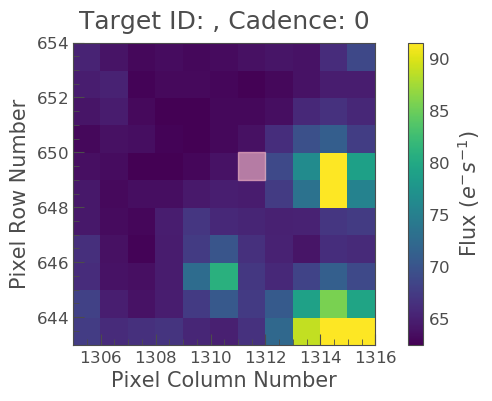

In [27]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [28]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [29]:
tpf.interact_sky(magnitude_limit=20)

In [32]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 8


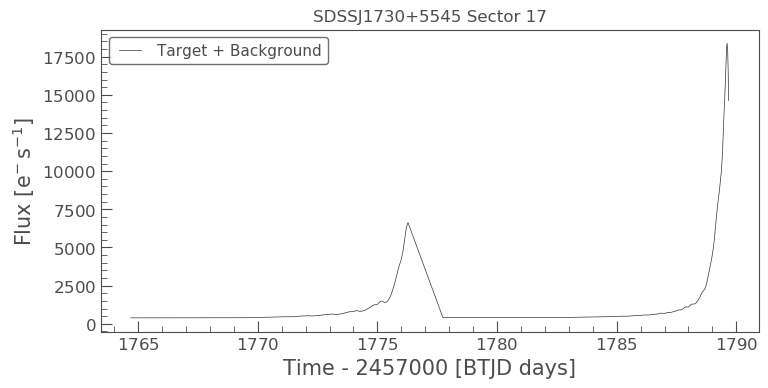

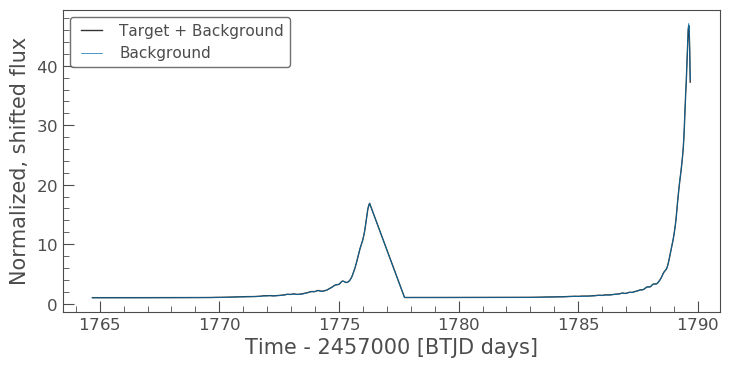

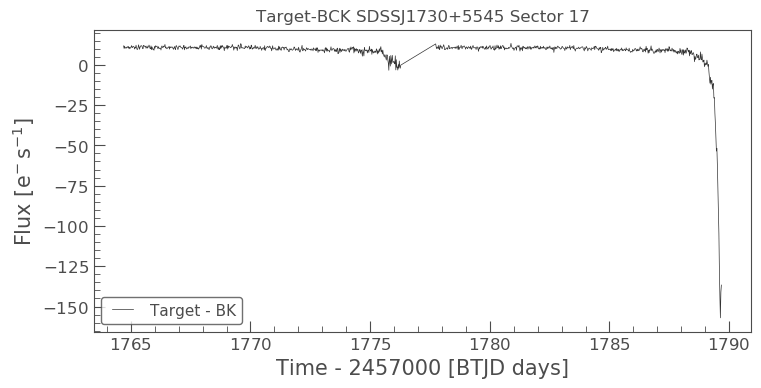

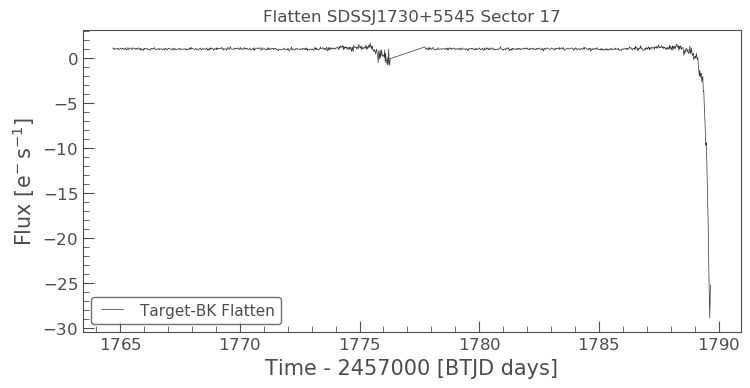

In [34]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

In [265]:
sectornum = 17
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

SearchError: Sorry, this sector isn't available yet. We're working on it!

In [ ]:
vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

In [ ]:
fig = vis.pixel_by_pixel()

In [ ]:
cross = eleanor.Crossmatch(dataeleanor)


In [ ]:
cross.two_minute()

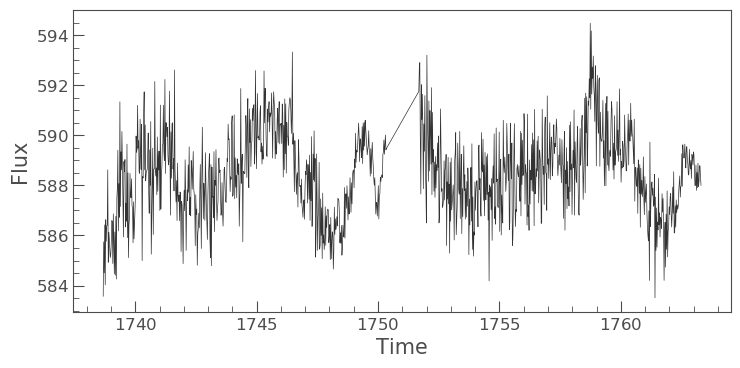

In [91]:
%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

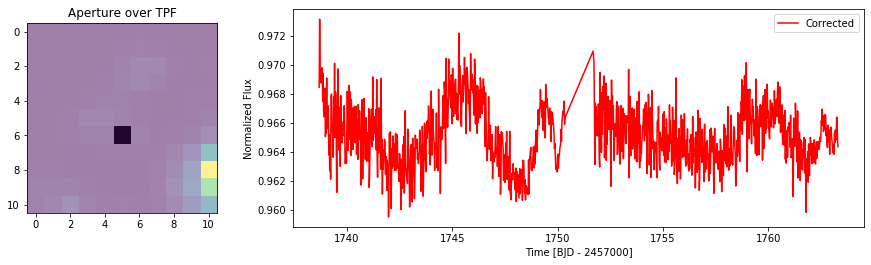

In [103]:
dataeleanor.get_lightcurve(aperture=sourcemask)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(dataeleanor.tpf[0])
ax1.imshow(sourcemask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(dataeleanor.aperture)

#ax2.plot(dataeleanor.time[q], dataeleanor.raw_flux[q]/np.nanmedian(dataeleanor.raw_flux[q]), 'k', label='Raw')
ax2.plot(dataeleanor.time[q], dataeleanor.corr_flux[q]/np.nanmedian(dataeleanor.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

# Sector 18 

In [36]:
sectornum = 18
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    





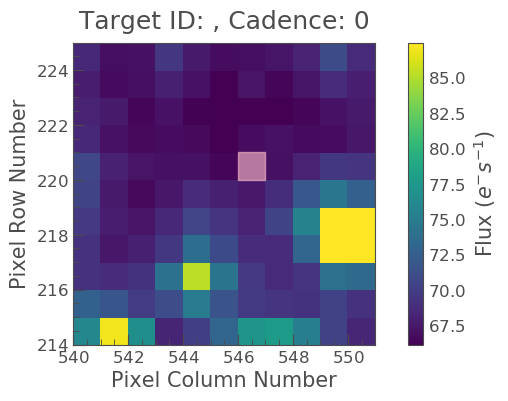

In [46]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [47]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [41]:
tpf.interact_sky(magnitude_limit=20)

In [42]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 9


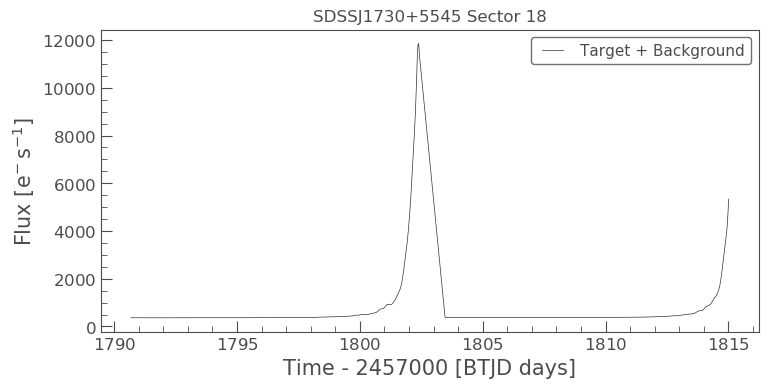

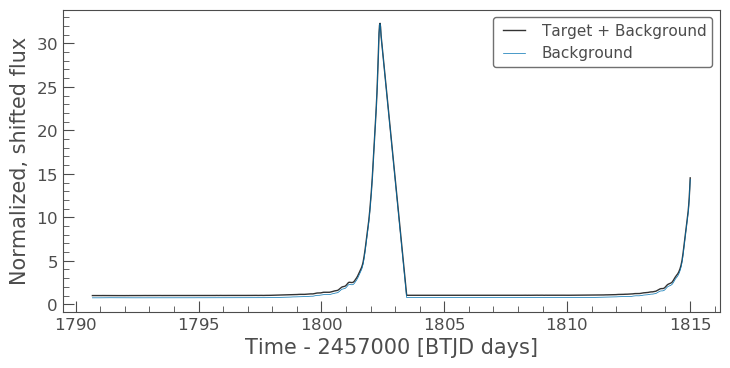

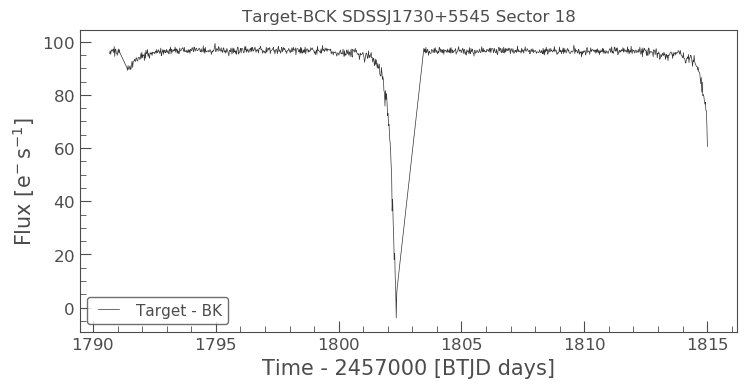

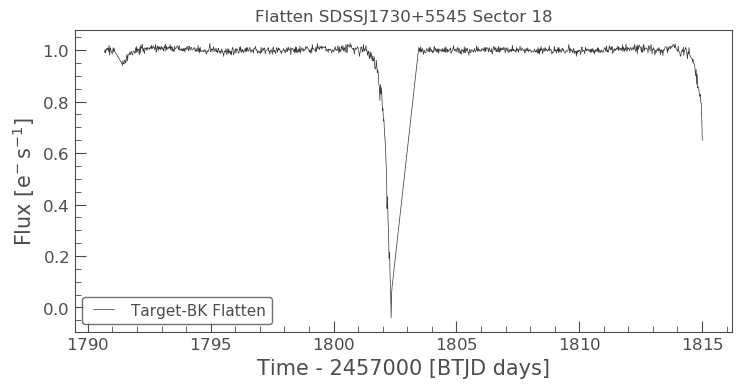

In [45]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [44]:
sectornum = 18
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

SearchError: Sorry, this sector isn't available yet. We're working on it!